For the first prototype let's try to reuse chessboard detector from openCV.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
cam = cv2.VideoCapture(0)

In [12]:
cam.release()

# From openCV

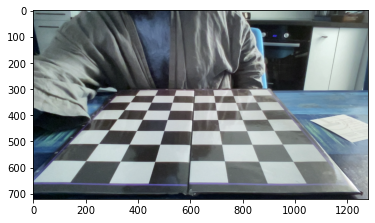

In [22]:
_, img = cam.read()
plt.imshow(img)

In [23]:
ret, corners = cv2.findChessboardCorners(img, (7, 7))

In [24]:
ret

False

This simplified version fails fast... Let's look for other methods.

# Some project found online

In [25]:
import scipy.spatial as spatial
import scipy.cluster as cluster
from collections import defaultdict
from statistics import mean

# Canny edge detection
def canny_edge(img, sigma=0.33):
    v = np.median(img)
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edges = cv2.Canny(img, lower, upper)
    return edges


# Hough line detection
def hough_line(edges, min_line_length=100, max_line_gap=10):
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 125, min_line_length, max_line_gap)
    lines = np.reshape(lines, (-1, 2))
    return lines

# Separate line into horizontal and vertical
def h_v_lines(lines):
    h_lines, v_lines = [], []
    for rho, theta in lines:
        if theta < np.pi / 4 or theta > np.pi - np.pi / 4:
            v_lines.append([rho, theta])
        else:
            h_lines.append([rho, theta])
    return h_lines, v_lines

# Find the intersections of the lines
def line_intersections(h_lines, v_lines):
    points = []
    for r_h, t_h in h_lines:
        for r_v, t_v in v_lines:
            a = np.array([[np.cos(t_h), np.sin(t_h)], [np.cos(t_v), np.sin(t_v)]])
            b = np.array([r_h, r_v])
            inter_point = np.linalg.solve(a, b)
            points.append(inter_point)
    return np.array(points)

# Hierarchical cluster (by euclidean distance) intersection points
def cluster_points(points):
    dists = spatial.distance.pdist(points)
    single_linkage = cluster.hierarchy.single(dists)
    flat_clusters = cluster.hierarchy.fcluster(single_linkage, 15, 'distance')
    cluster_dict = defaultdict(list)
    for i in range(len(flat_clusters)):
        cluster_dict[flat_clusters[i]].append(points[i])
    cluster_values = cluster_dict.values()
    clusters = map(lambda arr: (np.mean(np.array(arr)[:, 0]), np.mean(np.array(arr)[:, 1])), cluster_values)
    return sorted(list(clusters), key=lambda k: [k[1], k[0]])

# Average the y value in each row and augment original points
def augment_points(points):
    points_shape = list(np.shape(points))
    augmented_points = []
    for row in range(int(points_shape[0] / 11)):
        start = row * 11
        end = (row * 11) + 10
        rw_points = points[start:end + 1]
        rw_y = []
        rw_x = []
        for point in rw_points:
            x, y = point
            rw_y.append(y)
            rw_x.append(x)
        y_mean = mean(rw_y)
        for i in range(len(rw_x)):
            point = (rw_x[i], y_mean)
            augmented_points.append(point)
    augmented_points = sorted(augmented_points, key=lambda k: [k[1], k[0]])
    return augmented_points

In [34]:
def get_corners(img):
    # Low-level CV techniques (grayscale & blur)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_blur = cv2.blur(gray, (5, 5))
    # Canny algorithm
    edges = canny_edge(gray_blur)
    # Hough Transform
    lines = hough_line(edges)
    # Separate the lines into vertical and horizontal lines
    h_lines, v_lines = h_v_lines(lines)
    # Find and cluster the intersecting
    intersection_points = line_intersections(h_lines, v_lines)
    points = cluster_points(intersection_points)
    # Final coordinates of the board
    return augment_points(points)

(-105.99542770385743, 1279.5, 719.5, -0.5)

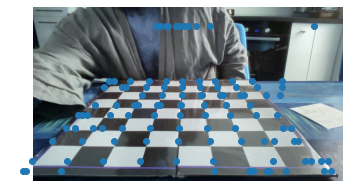

In [35]:
points = get_corners(img)

plt.imshow(img)
plt.scatter([p[0] for p in points],
            [p[1] for p in points])
plt.axis('off')

Simpler task

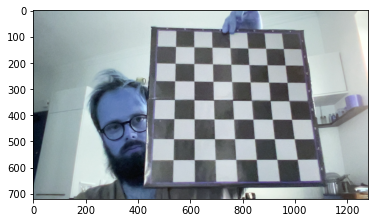

In [58]:
_, img = cam.read()
plt.imshow(img)

(-0.5, 1279.5, 719.5, -0.5)

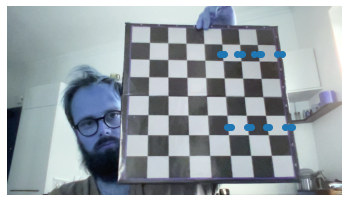

In [59]:
points = get_corners(img)

plt.imshow(img)
plt.scatter([p[0] for p in points],
            [p[1] for p in points])
plt.axis('off')

Clearly this detector is not robust enough.

Same problem also fails for openCV detector...

In [70]:
for c in range(3, 12):
    ret, corners = cv2.findChessboardCorners(img, (c, c))
    if ret:
        print(f'Found {c} corners')

Found 5 corners


In [71]:
ret, corners = cv2.findChessboardCorners(img, (5, 5))

(-0.5, 1279.5, 719.5, -0.5)

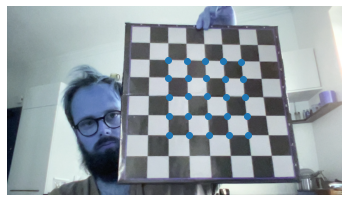

In [74]:
plt.imshow(img)
plt.scatter([p[0][0] for p in corners],
            [p[0][1] for p in corners])
plt.axis('off')

# Let's start from scratch

We might consider using some NN for detection, but that would lead to quite complex labeling. Instead let's look at other classical techniques that are more robust.

In [77]:
for c in range(3, 12):
    ret, corners = cv2.findChessboardCorners(img, (c, c), flags=cv2.CALIB_CB_ADAPTIVE_THRESH)
    if ret:
        print(f'Found {c} corners')

Found 5 corners


OpenCV expects white border so we could invert the image first.

In [88]:
img_inv = np.array(256 - img, dtype=np.uint8)

for c in range(3, 12):
    ret, corners = cv2.findChessboardCorners(img_inv, (c, c), flags=cv2.CALIB_CB_ADAPTIVE_THRESH)
    if ret:
        print(f'Found {c} corners')

Found 7 corners


(-0.5, 1279.5, 719.5, -0.5)

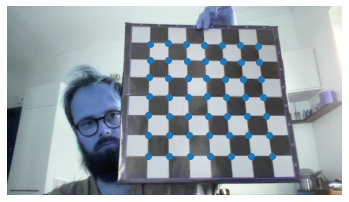

In [89]:
ret, corners = cv2.findChessboardCorners(img_inv, (7, 7))

plt.imshow(img)
plt.scatter([p[0][0] for p in corners],
            [p[0][1] for p in corners])
plt.axis('off')

Much better!

# Second try to use openCV checkerboard detector

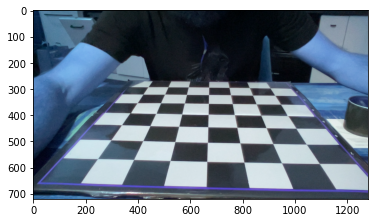

In [7]:
_, img = cam.read()
plt.imshow(img)

In [8]:
img_inv = np.array(256 - img, dtype=np.uint8)

for c in range(3, 12):
    ret, corners = cv2.findChessboardCorners(img_inv, (c, c), flags=cv2.CALIB_CB_ADAPTIVE_THRESH)
    if ret:
        print(f'Found {c} corners')

Found 7 corners


(-0.5, 1279.5, 719.5, -0.5)

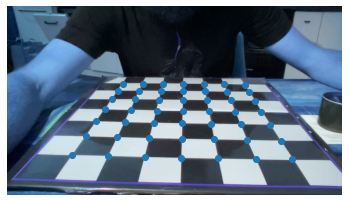

In [10]:
ret, corners = cv2.findChessboardCorners(img_inv, (7, 7), flags=cv2.CALIB_CB_ADAPTIVE_THRESH)

plt.imshow(img)
plt.scatter([p[0][0] for p in corners],
            [p[0][1] for p in corners])
plt.axis('off')

Cool it works!

In [11]:
def detect_checkerboard(img):
    img_inv = np.array(256 - img, dtype=np.uint8)
    ret, corners = cv2.findChessboardCorners(img_inv, (7, 7), flags=cv2.CALIB_CB_ADAPTIVE_THRESH)
    if ret:
        return corners
    else:
        print('Please reposition your board or adjust lighting')